202007Jp2 bloom timing

In [96]:
import datetime as dt
from erddapy import ERDDAP
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
from pathlib import Path
import xarray as xr

from salishsea_tools import places

%matplotlib inline

### Set up Model Results Getting

In [97]:
directory = '202007J-p2'
dir_path = Path(f"/data/sallen/results/MEOPAR/202007/{directory}")

In [98]:
drop_vars = [
    "time_centered",
    "time_centered_bounds",
    "time_counter_bounds",
    "nav_lat",
    "bounds_lat",
    "nav_lon",
    "bounds_lon",
    "area",
    "deptht_bounds",
]
chunks = {
    "time_counter": 1,
    "deptht": 1,
}

In [99]:
def prep_timeseries(dir_path, file_pattern, n_days): 
    ds_files = sorted(dir_path.glob(file_pattern))
    ds = xr.open_mfdataset(
        ds_files[:n_days],
        chunks=chunks,
        drop_variables=drop_vars,
    )
    S3y, S3x = places.PLACES['S3']['NEMO grid ji'][0], places.PLACES['S3']['NEMO grid ji'][1]
    fourkm = 8
    timeseries = ds.isel(deptht = 1, y = slice(S3y-fourkm, S3y+fourkm+1), 
                             x =  slice(S3x-fourkm, S3x+fourkm+1))
    
    return timeseries

### Set up Observations Getting

In [100]:
server = "https://salishsea.eos.ubc.ca/erddap"

protocol = "tabledap"

dataset_id = "ubcONCTWDP1mV18-01"

response = "nc"

variables = [
    "latitude",
    "longitude",
    "chlorophyll",
    "o2_concentration_corrected",
    "time",
]

variables2 = [
    "latitude",
    "longitude",
    "o2_concentration_corrected",
    "time",
]

    

fourkmlat = 4/110.574
fourkmlon = 4/(111.320*np.cos(50*np.pi/180.))
lon, lat = places.PLACES['S3']['lon lat']

### Plotting Functions

In [101]:
def model_plot(timeseries2015):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            timeseries2015.diatoms[:, j, i].plot(ax=axs[0], color='blue', marker='o')
            timeseries2015.diatoms[:, j, i].plot(ax=axs[1], color='blue', marker='o')
    ax2 = axs[0].twinx()
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            timeseries2015.nitrate[:, j, i].plot(ax=ax2, color='lightblue', marker='o')
    axs[0].grid()
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            (timeseries2015.diatoms+timeseries2015.flagellates+timeseries2015.ciliates)[:, j, i].plot(ax=axs[1], color='purple', marker='o', alpha=0.5);

In [102]:
def model_obs_comparison(timeseries2015, obs_pd, N2Chl=2.5, oxy=False):
    fig, axs = plt.subplots(1, 1, figsize=(7, 4))
    if oxy:
        ax2 = axs
        ax = ax2.twinx()
        obs_pd['o2_concentration_corrected (ml/l)'].plot(ax=ax2, marker='o', color='lime', linewidth=0, alpha=0.4, zorder=6);
    else:
        ax = axs
        obs_pd['chlorophyll (ug/l)'].plot(ax=ax, marker='o', color='green', linewidth=0, zorder=2)
    for i in range(timeseries2015.x.shape[0]):
        for j in range(timeseries2015.y.shape[0]):
            ((timeseries2015.diatoms+timeseries2015.flagellates+timeseries2015.ciliates)[:, j, i]*N2Chl).plot(ax=ax, color='purple', 
                                                                                                              marker='.', alpha=0.5, linewidth=0, zorder=3);


# 2015

## Model Results

In [70]:
year = 2015
months_regex = '0[23]'
file_pattern = f"SalishSea_1d_{year}*ptrc_T*{year}{months_regex}??.nc"
timeseries = prep_timeseries(dir_path, file_pattern, -1)

In [10]:
timeseries.load(scheduler='processes', num_workers=4);

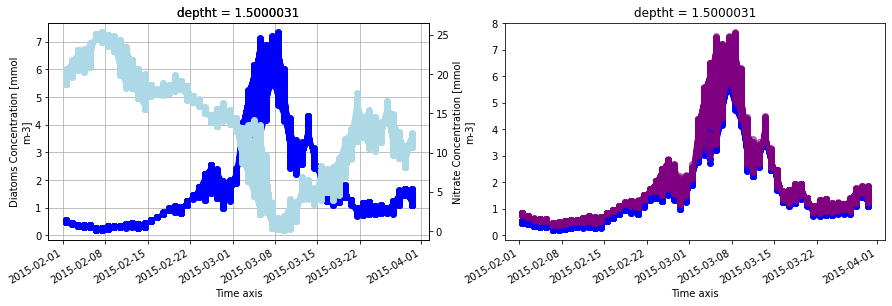

In [11]:
model_plot(timeseries)

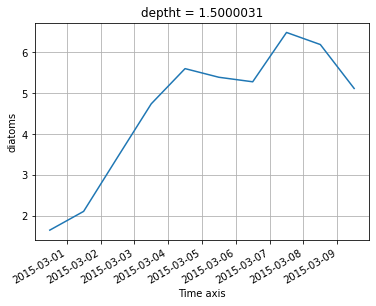

In [12]:
timeseries.diatoms[28-1:28-1+10].mean(axis=1).mean(axis=1).plot();
plt.grid()

Bloom is March 7.  This bloom is two days early.

## Observations

In [71]:
constraints = {
    "time>=": "2015-02-01T00:00:00Z",
    "time<=": "2015-04-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}

In [72]:
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [73]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,)

In [55]:
obs2 = ERDDAP(server=server, protocol=protocol,)

obs2.dataset_id = dataset_id
obs2.variables = variables2
obs2.constraints = constraints

In [56]:
obs2_pd = obs2.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

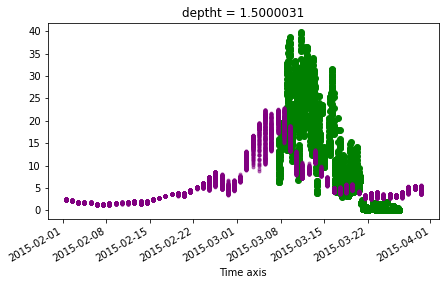

In [19]:
model_obs_comparison(timeseries, obs_pd, N2Chl=3)

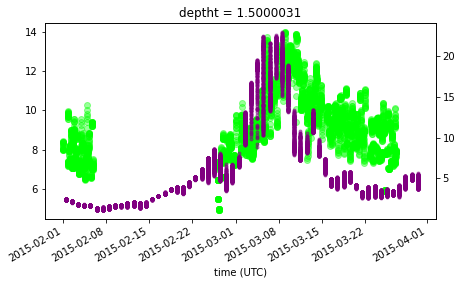

In [20]:
model_obs_comparison(timeseries, obs_pd, N2Chl=3, oxy=True)

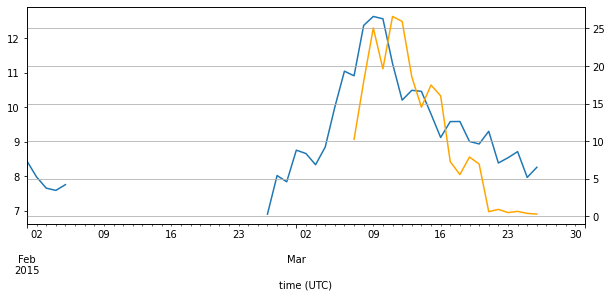

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax2 = ax.twinx()
obs_pd['o2_concentration_corrected (ml/l)'].groupby(pd.Grouper(freq='1D')).mean().plot(ax=ax)
obs_pd['chlorophyll (ug/l)'].groupby(pd.Grouper(freq='1D')).mean().plot(ax=ax2, color='orange');
ax.grid()

Bloom is March 9.

# 2016

## Model Results

In [63]:
year = 2016
months_regex = '0[34]'
file_pattern = f"SalishSea_1d_{year}*ptrc_T*{year}{months_regex}??.nc"
timeseries = prep_timeseries(dir_path, file_pattern, -1)

In [23]:
timeseries.load(scheduler='processes', num_workers=4);

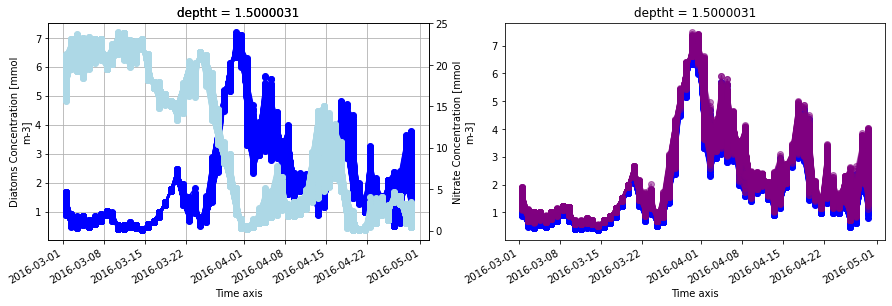

In [24]:
model_plot(timeseries)

In [25]:
timeseries.diatoms[29-1:32-1].mean(axis=1).mean(axis=1)

<xarray.DataArray 'diatoms' (time_counter: 3)>
array([5.8129463, 6.607595 , 6.5060472], dtype=float32)
Coordinates:
    deptht        float32 1.5
  * time_counter  (time_counter) datetime64[ns] 2016-03-29T12:00:00 ... 2016-...

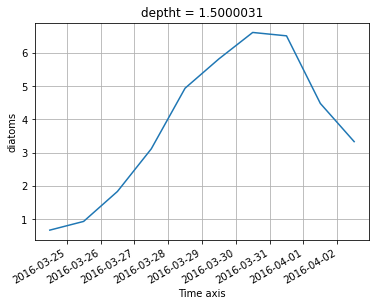

In [26]:
timeseries.diatoms[28-5:28-5+10].mean(axis=1).mean(axis=1).plot();
plt.grid()

Bloom date is March 30.  This value is only 9 days late.

## Observations

In [64]:
constraints = {
    "time>=": "2016-03-01T00:00:00Z",
    "time<=": "2016-05-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}

In [65]:
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [66]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

In [30]:
obs2 = ERDDAP(server=server, protocol=protocol,)

obs2.dataset_id = dataset_id
obs2.variables = variables2
obs2.constraints = constraints

In [31]:
obs2_pd = obs2.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

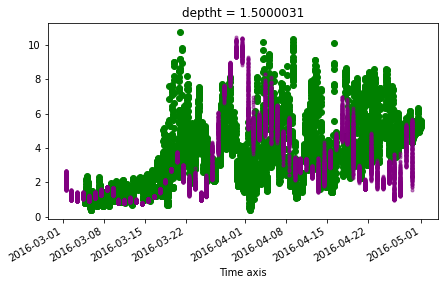

In [32]:
model_obs_comparison(timeseries, obs_pd, N2Chl=1.4)

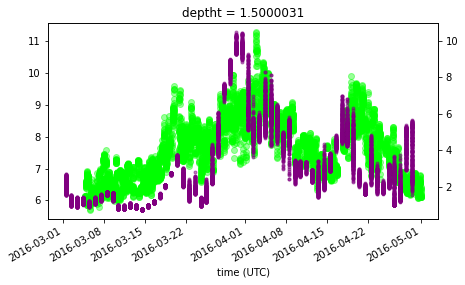

In [33]:
model_obs_comparison(timeseries, obs_pd, N2Chl=1.4, oxy=True)

<AxesSubplot:label='3d86ce11-f5fb-454b-9104-017226d1ca25', xlabel='time (UTC)'>

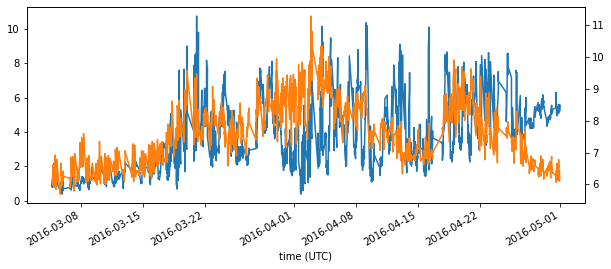

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax2 = ax.twinx()
obs_pd['chlorophyll (ug/l)'].plot(ax=ax)
obs_pd['o2_concentration_corrected (ml/l)'].plot(ax=ax2, color='tab:orange')

<AxesSubplot:label='d88cf9a5-be5e-4da2-9f40-7fdc4688b9df', xlabel='time (UTC)'>

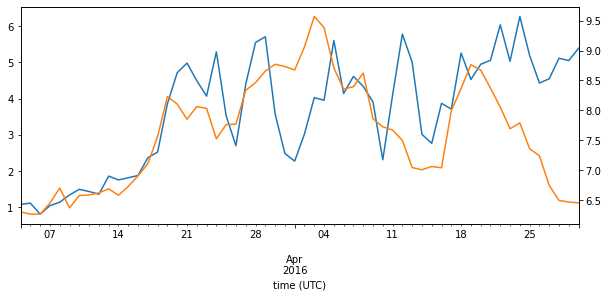

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax2 = ax.twinx()
obs_pd['chlorophyll (ug/l)'].groupby(pd.Grouper(freq='1D')).mean().plot(ax=ax)
obs_pd['o2_concentration_corrected (ml/l)'].groupby(pd.Grouper(freq='1D')).mean().plot(ax=ax2, color='tab:orange')

In [67]:
obs_pd['chlorophyll (ug/l)'].groupby(pd.Grouper(freq='1D')).mean()[10:29]

time (UTC)
2016-03-14 00:00:00+00:00    1.752116
2016-03-15 00:00:00+00:00    1.811605
2016-03-16 00:00:00+00:00    1.873673
2016-03-17 00:00:00+00:00    2.365277
2016-03-18 00:00:00+00:00    2.522423
2016-03-19 00:00:00+00:00    3.855856
2016-03-20 00:00:00+00:00    4.710750
2016-03-21 00:00:00+00:00    4.978662
2016-03-22 00:00:00+00:00    4.493710
2016-03-23 00:00:00+00:00    4.065250
2016-03-24 00:00:00+00:00    5.287270
2016-03-25 00:00:00+00:00    3.523971
2016-03-26 00:00:00+00:00    2.696661
2016-03-27 00:00:00+00:00    4.394448
2016-03-28 00:00:00+00:00    5.547918
2016-03-29 00:00:00+00:00    5.706081
2016-03-30 00:00:00+00:00    3.574641
2016-03-31 00:00:00+00:00    2.481376
2016-04-01 00:00:00+00:00    2.270905
Freq: D, Name: chlorophyll (ug/l), dtype: float64

Bloom date is March 21.

# 2017

## Model Results

In [79]:
year = 2017
months_regex = '0[234]'
file_pattern = f"SalishSea_1d_{year}*ptrc_T*{year}{months_regex}??.nc"
timeseries = prep_timeseries(dir_path, file_pattern, -1)

In [90]:
timeseries.load(scheduler='processes', num_workers=4);

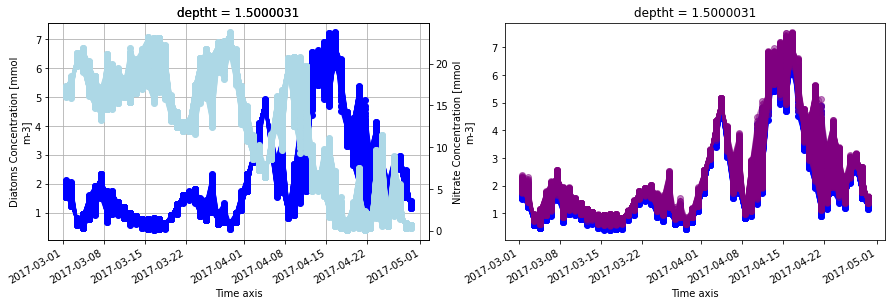

In [40]:
model_plot(timeseries)

In [91]:
timeseries.diatoms[32-1:42-1].mean(axis=1).mean(axis=1)

<xarray.DataArray 'diatoms' (time_counter: 10)>
array([2.0039144 , 2.886315  , 3.8923025 , 4.793111  , 3.5180378 ,
       2.0958817 , 2.352351  , 0.97753805, 1.5064913 , 1.9729589 ],
      dtype=float32)
Coordinates:
    deptht        float32 1.5
  * time_counter  (time_counter) datetime64[ns] 2017-04-01T12:00:00 ... 2017-...

Split bloom.

## Observations

In [80]:
constraints = {
    "time>=": "2017-02-01T00:00:00Z",
    "time<=": "2017-05-01T00:00:00Z",
    "latitude>=": lat - fourkmlat,
    "latitude<=": lat + fourkmlat,
    "longitude>=": lon - fourkmlon,
    "longitude<=": lon + fourkmlon,
}
obs = ERDDAP(server=server, protocol=protocol,)

obs.dataset_id = dataset_id
obs.variables = variables
obs.constraints = constraints

In [81]:
obs_pd = obs.to_pandas(index_col="time (UTC)", parse_dates=True,).dropna()

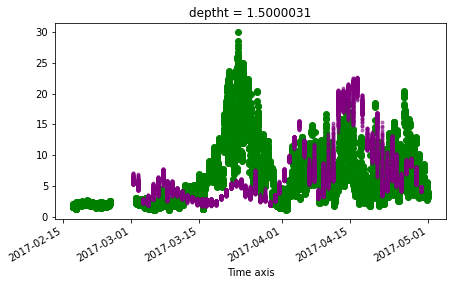

In [44]:
model_obs_comparison(timeseries, obs_pd, N2Chl=3)

In [82]:
obs2 = ERDDAP(server=server, protocol=protocol,)

obs2.dataset_id = dataset_id
obs2.variables = variables2
obs2.constraints = constraints

In [83]:
obs2_pd = obs2.to_pandas(index_col="time (UTC)", parse_dates=True,)

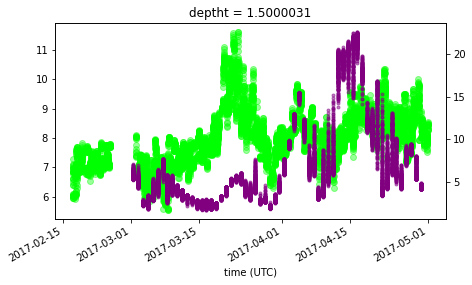

In [50]:
model_obs_comparison(timeseries, obs_pd, N2Chl=3, oxy=True)

<AxesSubplot:label='e8236cdb-e04f-438c-9538-6b122c719048', xlabel='time (UTC)'>

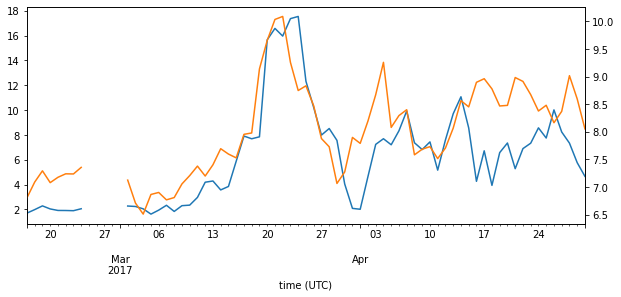

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax2 = ax.twinx()
obs_pd['chlorophyll (ug/l)'].groupby(pd.Grouper(freq='1D')).mean().plot(ax=ax)
obs_pd['o2_concentration_corrected (ml/l)'].groupby(pd.Grouper(freq='1D')).mean().plot(ax=ax2, color='tab:orange');

In [86]:
obs_pd['chlorophyll (ug/l)'].groupby(pd.Grouper(freq='1D')).mean()[30:50]

time (UTC)
2017-03-19 00:00:00+00:00     7.843336
2017-03-20 00:00:00+00:00    15.651704
2017-03-21 00:00:00+00:00    16.573289
2017-03-22 00:00:00+00:00    15.954556
2017-03-23 00:00:00+00:00    17.360318
2017-03-24 00:00:00+00:00    17.536048
2017-03-25 00:00:00+00:00    12.315041
2017-03-26 00:00:00+00:00    10.207530
2017-03-27 00:00:00+00:00     7.983031
2017-03-28 00:00:00+00:00     8.511930
2017-03-29 00:00:00+00:00     7.555994
2017-03-30 00:00:00+00:00     4.045476
2017-03-31 00:00:00+00:00     2.081824
2017-04-01 00:00:00+00:00     2.010417
2017-04-02 00:00:00+00:00     4.642109
2017-04-03 00:00:00+00:00     7.234256
2017-04-04 00:00:00+00:00     7.688755
2017-04-05 00:00:00+00:00     7.202931
2017-04-06 00:00:00+00:00     8.328430
2017-04-07 00:00:00+00:00     9.922666
Freq: D, Name: chlorophyll (ug/l), dtype: float64

In [88]:
#Bloom is March 21

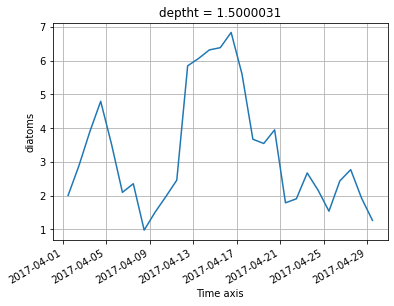

In [94]:
timeseries.diatoms[31:90].mean(axis=1).mean(axis=1).plot();
plt.grid()

In [95]:
#Bloom is April 4, this is 14 days late.